In [2]:
import os
os.chdir('../../data')

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

In [4]:
DATASET_INFO_DIR = './yt8m-clips-dataset-info'
EMBEDS_DIR = 'weighted-contrastive-embeds'

In [5]:
splits = ['train', 'dev', 'test']
media = ['text', 'audio', 'video']

In [6]:
clip_df = pd.read_json(os.path.join(DATASET_INFO_DIR, 'train', 'clip-info.jsonl'), lines=True)

print(clip_df.info())

clip_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58847 entries, 0 to 58846
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   vid              58847 non-null  object 
 1   clip_no          58847 non-null  int64  
 2   audio_clip_name  58847 non-null  object 
 3   audio_clip_dur   58847 non-null  float64
 4   video_clip_name  58847 non-null  object 
 5   video_clip_dur   58847 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.7+ MB
None


,vid,clip_no,audio_clip_name,audio_clip_dur,video_clip_name,video_clip_dur
0,6YIzDW8HBPo,23,6YIzDW8HBPo-audio-23.mp3,8.0,6YIzDW8HBPo-video-23.mp4,8.01
1,6YIzDW8HBPo,9,6YIzDW8HBPo-audio-9.mp3,8.0,6YIzDW8HBPo-video-9.mp4,8.01
2,6YIzDW8HBPo,24,6YIzDW8HBPo-audio-24.mp3,8.0,6YIzDW8HBPo-video-24.mp4,8.01
3,6YIzDW8HBPo,15,6YIzDW8HBPo-audio-15.mp3,8.0,6YIzDW8HBPo-video-15.mp4,8.01
4,6YIzDW8HBPo,4,6YIzDW8HBPo-audio-4.mp3,8.0,6YIzDW8HBPo-video-4.mp4,8.01


In [7]:
vid_df = pd.read_json(os.path.join(DATASET_INFO_DIR, 'train', 'video-info.jsonl'), lines=True)

print(vid_df.info())

vid_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   vid                4831 non-null   object 
 1   n_clips            4831 non-null   int64  
 2   n_sampled_clips    4831 non-null   int64  
 3   audio_dur          4831 non-null   float64
 4   sampled_audio_dur  4831 non-null   float64
 5   video_dur          4831 non-null   float64
 6   sampled_video_dur  4831 non-null   float64
 7   split              4831 non-null   object 
 8   labels             4831 non-null   object 
 9   title              4831 non-null   object 
 10  description        4831 non-null   object 
 11  tags               4831 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 453.0+ KB
None


,vid,n_clips,n_sampled_clips,audio_dur,sampled_audio_dur,video_dur,sampled_video_dur,split,labels,title,description,tags
0,6YIzDW8HBPo,28,6,224.398,48.0,224.29,48.06,train1,[Music video],Sharper Than A Knife (Lyric Video) (Pete Hammo...,Dedicated to David Lynch. Animated by John von...,"parralox,sharper,than,knife,2012,pwl,saw,stock..."
1,4EYfkE6fczE,28,6,226.615,48.0,226.59,48.06,train1,[Music video],San Quinn - Realest Intro Ever,Music video by San Quinn performing Realest In...,"San Quinn,Realest Intro Ever,Realest,Intro,Eve..."
2,2aAIB9-0wrc,42,9,338.013,72.0,338.00,72.09,train1,"[Concert, Music video]",EU TENHO UMA ALIANÇA (DVD ALIANÇA) - André Val...,Gravação ao vivo do CD/DVD Aliança na Igreja B...,"EU TENHO UMA ALIANÇA,ALIANÇA,André Valadão,Igr..."
3,8kd4GNKcvc0,30,7,242.753,56.0,242.71,56.07,train1,"[Concert, Musician]",Big Time Rush - Worldwide,"Big Time Rush - Worldwide\nJingle Jam, Blue Cr...","Big,Time,Rush,Worldwide,Jingle,Jam,Rochester,N..."
4,3UoFEJ4e8KA,28,6,224.688,48.0,224.60,48.00,train1,[Concert],Hazama - Lagu Untukmu,GSA Bukit Tinggi Klang,"Hazama,Lagu,Untukmu,AF,GSA"


In [8]:
video_features_data = dict()
for split in splits:
    split_data = list()
    vid_df = pd.read_json(os.path.join(DATASET_INFO_DIR, split, 'video-info.jsonl'), lines=True)
    clip_df = pd.read_json(os.path.join(DATASET_INFO_DIR, split, 'clip-info.jsonl'), lines=True)
    for _, row in vid_df.iterrows():
        vid = row['vid']
        labels = row['labels']
        
        if split == 'train':
            n_clips = row['n_sampled_clips']
        else:
            n_clips = row['n_clips']
        clip_nos = clip_df[clip_df['vid'] == vid]['clip_no'].tolist()
        try:
            assert n_clips == len(clip_nos)
        except:
            print(f'Insufficient clips in {split} for {vid}: expected {n_clips}, found {len(clip_nos)}')
        
        audio_embeds = list()
        video_embeds = list()
        for clip_no in clip_nos:
            audio_file_name = f'{vid}-{clip_no}-audio-emb.npy'
            audio_embed = np.load(os.path.join(EMBEDS_DIR, split, 'audio', audio_file_name))
            audio_embeds.append(audio_embed)
            video_file_name = f'{vid}-{clip_no}-video-emb.npy'
            video_embed = np.load(os.path.join(EMBEDS_DIR, split, 'video', video_file_name))
            video_embeds.append(video_embed)
        audio_embeds = np.array(audio_embeds)
        video_embeds = np.array(video_embeds)
        split_data.append({
            'vid': vid,
            'audio_features': audio_embeds,
            'video_features': video_embeds,
            'labels': labels
        })
    video_features_data[split] = split_data

video_features_data.keys()

Insufficient clips in train for oKcBv8084ZU: expected 34, found 33
Insufficient clips in train for ukk0TpAkJpQ: expected 23, found 22
Insufficient clips in test for 9sMjAn5tP3U: expected 40, found 39
Insufficient clips in test for QyIOvRn2Z_8: expected 61, found 60
Insufficient clips in test for ZiAau4ESESs: expected 34, found 33
Insufficient clips in test for hlRpflYurPk: expected 25, found 24


dict_keys(['train', 'dev', 'test'])

In [9]:
len(video_features_data['train']), len(video_features_data['dev']), len(video_features_data['test'])

(4831, 499, 461)

In [10]:
video_features_data['train'][0]

{'vid': '6YIzDW8HBPo',
 'audio_features': array([[-0.09538653,  0.07119057, -0.06264777, ...,  0.03291445,
          0.07796044,  0.01284727],
        [-0.28774795,  0.16270117, -0.04386227, ...,  0.10613745,
          0.15983982, -0.01497643],
        [-0.24755254,  0.02329738, -0.11598207, ...,  0.20974664,
          0.00330581,  0.03020374],
        [-0.29136866,  0.1302152 , -0.06050174, ...,  0.06319528,
          0.04143047, -0.04133729],
        [-0.24481118,  0.22861145, -0.11998299, ...,  0.09575342,
          0.10455899,  0.04762237],
        [-0.30877241,  0.16691923, -0.00302748, ...,  0.13375516,
         -0.00313855, -0.15067163]], dtype=float32),
 'video_features': array([[-0.16368051, -0.12115378, -0.4386084 , ...,  0.18957224,
         -0.13153996, -0.22677268],
        [-0.30147895,  0.0601085 , -0.41409233, ...,  0.00459911,
          0.04485491, -0.14953198],
        [ 0.01901044, -0.01648029, -0.35422105, ...,  0.03543382,
         -0.07611051, -0.09376191],
      

In [11]:
video_features_data['train'][0]['video_features'].mean(axis=0).shape

(300,)

In [12]:
mean_data = dict()
for split in splits:
    split_data = video_features_data[split]
    all_audio = list()
    all_video = list()
    all_labels = list()
    for instance in split_data:
        all_audio.append(instance['audio_features'].mean(axis=0))
        all_video.append(instance['video_features'].mean(axis=0))
        all_labels.append(instance['labels'])
    all_audio = np.array(all_audio)
    all_video = np.array(all_video)
    mean_data[split] = {'audio': all_audio, 'video': all_video, 'labels': all_labels}

mean_data.keys()

dict_keys(['train', 'dev', 'test'])

In [13]:
mean_data['train'].keys()

dict_keys(['audio', 'video', 'labels'])

In [14]:
mean_data['train']['audio'].shape, mean_data['train']['video'].shape, len(mean_data['train']['labels'])

((4831, 300), (4831, 300), 4831)

In [15]:
all_labels = set()
[all_labels.update(labels) for labels in mean_data['train']['labels']]
len(all_labels)
label_enc = LabelEncoder()
label_enc.fit(list(all_labels))

LabelEncoder()

In [16]:
multi_lab_bin = MultiLabelBinarizer()
mean_data['train']['mult_lab'] = multi_lab_bin.fit_transform(
    [label_enc.transform(labels) for labels in mean_data['train']['labels']])

mean_data['train']['mult_lab'].shape

(4831, 45)

In [17]:
mean_data['dev']['mult_lab'] = multi_lab_bin.transform(
    [label_enc.transform(labels) for labels in mean_data['dev']['labels']])

mean_data['dev']['mult_lab'].shape

(499, 45)

In [18]:
mean_data['test']['mult_lab'] = multi_lab_bin.transform(
    [label_enc.transform(labels) for labels in mean_data['test']['labels']])

mean_data['test']['mult_lab'].shape

(461, 45)

In [19]:
x_train = np.hstack((mean_data['train']['audio'], mean_data['train']['video']))
x_dev = np.hstack((mean_data['dev']['audio'], mean_data['dev']['video']))
x_test = np.hstack((mean_data['test']['audio'], mean_data['test']['video']))

y_train = mean_data['train']['mult_lab']
y_dev = mean_data['dev']['mult_lab']
y_test = mean_data['test']['mult_lab']

x_train.shape, x_dev.shape, x_test.shape, y_train.shape, y_dev.shape, y_test.shape

((4831, 600), (499, 600), (461, 600), (4831, 45), (499, 45), (461, 45))

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(300,100), max_iter=1000)
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(300, 100), max_iter=1000)

In [21]:
pred_train = mlp.predict(x_train)
pred_dev = mlp.predict(x_dev)
pred_test = mlp.predict(x_test)

pred_train.shape, pred_dev.shape, pred_test.shape

((4831, 45), (499, 45), (461, 45))

In [22]:
print('train accuracy:', accuracy_score(y_true=y_train, y_pred=pred_train))

train accuracy: 0.9929621196439661


In [23]:
print('dev accuracy:', accuracy_score(y_true=y_dev, y_pred=pred_dev))

dev accuracy: 0.5210420841683366


In [24]:
print('test accuracy:', accuracy_score(y_true=y_test, y_pred=pred_test))
print('test f1:', f1_score(y_true=y_test, y_pred=pred_test, average='weighted'))
print('test precision:', precision_score(y_true=y_test, y_pred=pred_test, average='weighted'))
print('test recall:', recall_score(y_true=y_test, y_pred=pred_test, average='weighted'))
print('test hamming loss:', hamming_loss(y_true=y_test, y_pred=pred_test))

test accuracy: 0.49891540130151846
test f1: 0.7286217140328326
test precision: 0.7538748217646134
test recall: 0.718475073313783
test hamming loss: 0.02482525909857797


/Users/sagar/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/sagar/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sagar/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
cm_test = multilabel_confusion_matrix(y_true=y_test, y_pred=pred_test)

cm_test.shape

(45, 2, 2)

In [32]:
clf_labels = label_enc.inverse_transform(range(len(label_enc.classes_)))

clf_labels

array(['Accordion', 'Acoustic guitar', 'Bagpipes', 'Banjo',
       'Brass instrument', 'Cello', 'Choir', 'Clarinet', 'Concert',
       'Cymbal', 'Diatonic button accordion', 'Disc jockey', 'Drum',
       'Drum kit', 'Drum stick', 'Drummer', 'Electric guitar',
       'Electronic keyboard', 'Fiddle', 'Flamenco', 'Flute', 'Guitar',
       'Guitar Hero', 'Guitar amplifier', 'Harmonica', 'Marching band',
       'Mixtape', 'Music festival', 'Music video', 'Musical ensemble',
       'Musical keyboard', 'Musician', 'Orchestra', 'Organ (music)',
       'Pianist', 'Piano', 'Quartet', 'Saxophone', 'Snare drum',
       'String instrument', 'Tenor saxophone', 'Trombone', 'Trumpet',
       'Viola', 'Violin'], dtype='<U25')

In [34]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

    return

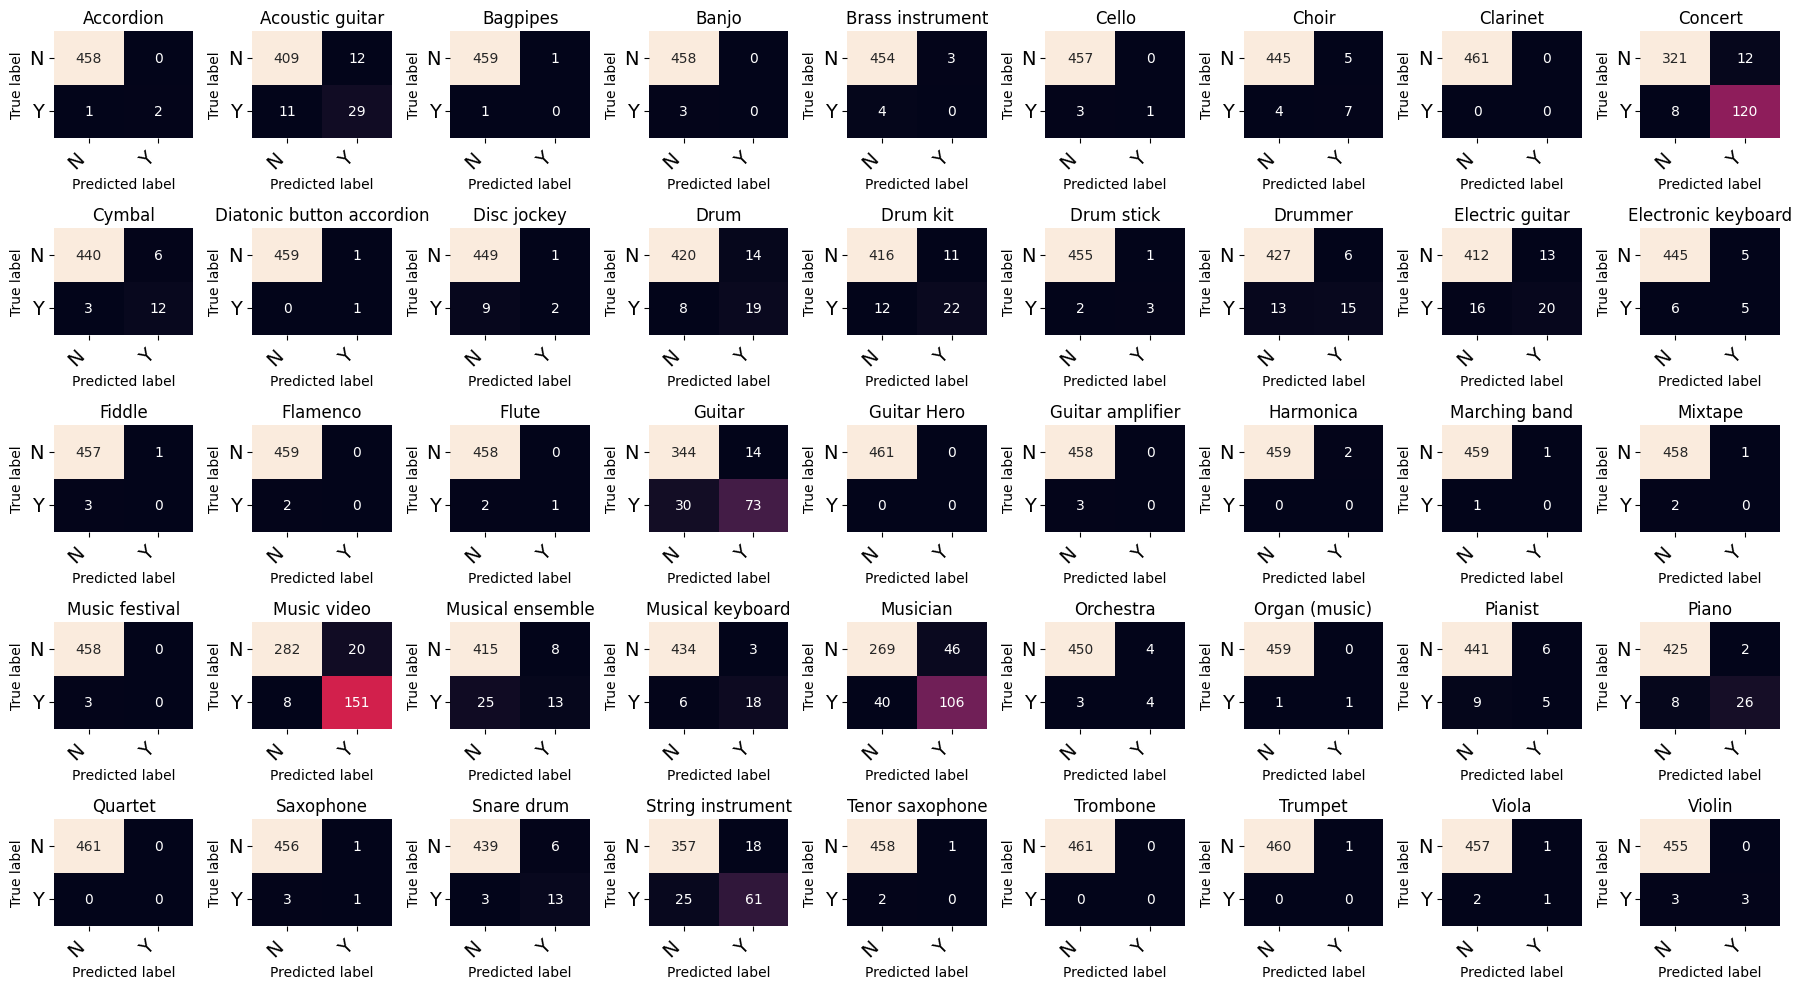

In [38]:
fig, ax = plt.subplots(5, 9, figsize=(18, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), cm_test, clf_labels):
    print_confusion_matrix(cfs_matrix, axes, label, ['N', 'Y'])

fig.tight_layout()
plt.show()